In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import os
from sklearn.model_selection import train_test_split

%matplotlib inline
np.random.seed(1)

In [2]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [3]:
filenames=os.listdir("./dataset/train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

print(df)

           filename  category
0         cat.0.jpg         0
1         cat.1.jpg         0
2        cat.10.jpg         0
3       cat.100.jpg         0
4      cat.1000.jpg         0
...             ...       ...
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

[25000 rows x 2 columns]


In [4]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15
print(train_df)

            filename category
0       dog.8479.jpg      dog
1        dog.876.jpg      dog
2      cat.10915.jpg      cat
3      dog.10127.jpg      dog
4      cat.11377.jpg      cat
...              ...      ...
19995   dog.6916.jpg      dog
19996     cat.36.jpg      cat
19997  cat.10771.jpg      cat
19998   dog.1713.jpg      dog
19999   dog.8788.jpg      dog

[20000 rows x 2 columns]


In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./dataset/train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [8]:
epochs=10
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/10
1333/1333 [==============================] - 736s 551ms/step - loss: 0.7393 - accuracy: 0.6385 - val_loss: 0.6631 - val_accuracy: 0.6723 - lr: 0.0010
Epoch 2/10
1333/1333 [==============================] - 588s 441ms/step - loss: 0.5621 - accuracy: 0.7195 - val_loss: 0.5517 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 3/10
1333/1333 [==============================] - 706s 530ms/step - loss: 0.5094 - accuracy: 0.7573 - val_loss: 0.5530 - val_accuracy: 0.7459 - lr: 0.0010
Epoch 4/10
1333/1333 [==============================] - 799s 600ms/step - loss: 0.4822 - accuracy: 0.7730 - val_loss: 0.4934 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 5/10
1333/1333 [==============================] - 760s 570ms/step - loss: 0.4476 - accuracy: 0.7958 - val_loss: 0.5025 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 6/10
1333/1333 [==============================] - 940s 705ms/step - loss: 0.4273 - accuracy: 0.8061 - val_loss: 0.3781 - val_accuracy: 0.8340 - lr: 0.0010
Epoch 7/10
1333/1333 [============

6258
1/1 [==============================] - 0s 40ms/step
513
1/1 [==============================] - 0s 41ms/step
1220
1/1 [==============================] - 0s 36ms/step
5746
1/1 [==============================] - 0s 33ms/step
3503
1/1 [==============================] - 0s 32ms/step
2173
1/1 [==============================] - 0s 37ms/step
10087
1/1 [==============================] - 0s 33ms/step
10006
1/1 [==============================] - 0s 34ms/step
7131
1/1 [==============================] - 0s 43ms/step


<Figure size 1200x2400 with 0 Axes>

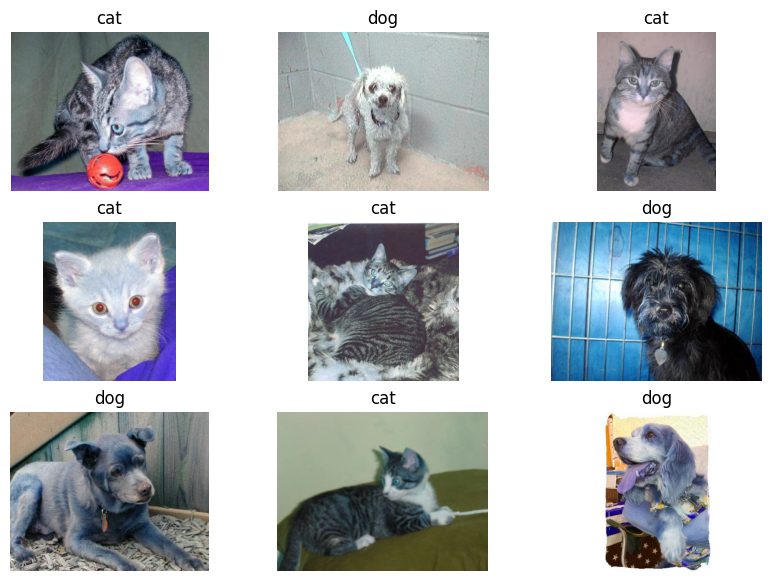

In [14]:
import cv2
plt.figure(figsize=(12, 24))
sample_test=os.listdir("./dataset/test")
fig = plt.figure(figsize=(10, 7))
rows = 3
columns = 3
for i in range(1,10):
        fig.add_subplot(rows, columns, i)
        ind = np.random.randint(0,12500)
        print(ind)
        img = cv2.imread('./dataset/test/'+ str(ind) + '.jpg')
        img_in = cv2.resize(img,(128,128))
        img_in = np.reshape(img_in,[1,Image_Height,Image_Width,Image_Channels])
        img_in = img_in/255
        lab = model.predict(img_in)
        lab = np.argmax(lab)
        label = 'cat' if lab == 0 else 'dog'
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
        # plt.show

In [15]:
model.save("model1_catsVSdogs_10epoch.h5")